In [1]:
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

1.8.1+cu101
True


device(type='cuda', index=0)

## 读取数据

In [2]:
root_dir = r"../小型CSV数据/weather_dataset"
train_dir = os.path.join(root_dir, "train_dir")
test_dir = os.path.join(root_dir, "test_dir")

## 数据增强方法
- torchvision.transforms.RandomCrop() # 随机裁切
- torchvision.transforms.CenterCrop() # 中心裁切
- torchvision.transforms.RandomHorizontalFlip(p=0.5) # 随机水平翻转，p代表概率大小
- torchvision.transforms.RandomVerticalFlip(p=0.5) # 随机上下翻转
- torchvision.transforms.RandomRotation() # 随机旋转
- torchvision.transforms.ColorJitter(brightness=1) # 亮度
- torchvision.transforms.ColorJitter(contrast=1) # 对比度
- torchvision.transforms.ColorJitter(saturation=1) # 饱和度
- torchvision.transforms.ColorJitter(hue=1) # 颜色
- torchvision.transforms.RandomGrayscale(p=0.5) # 随机灰度化


In [3]:
from torchvision import transforms
traindata_transform_ops = transforms.Compose([
                             transforms.Resize(size=(224, 224)),
                             transforms.RandomCrop(size=(192, 192)),
                             transforms.RandomHorizontalFlip(),
                             transforms.RandomRotation(degrees=0.2),
                             transforms.ColorJitter(brightness=0.5),
                             transforms.ColorJitter(contrast=0.5),
                             transforms.ToTensor(),
                             transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

testdata_transform_ops = transforms.Compose([
                             transforms.Resize(size=(192, 192)),
                             transforms.ToTensor(),
                             transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=traindata_transform_ops)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=testdata_transform_ops)
train_dataset.classes, train_dataset.class_to_idx, len(train_dataset)

(['cloudy', 'rain', 'shine', 'sunrise'],
 {'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3},
 900)

In [4]:
traindata_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=32,
                                               shuffle=True)
testdata_loader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=32)                                          

## 创建模型

In [5]:
model = torchvision.models.vgg16(pretrained=True)
model.to(device=device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
model.features #对应的就是VGG16的卷积部分，打印出模型结构的时候就能看到相应部分的名称

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [7]:
for param in model.features.parameters():
    param.requires_grad = False #冻结卷积部分的参数，不再进行梯度更新

In [8]:
model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

In [9]:
model.classifier[-1].out_features = 4 # 将分类层最后一层的输出单元个数由1000变成4
# 前面的卷积层是被冻结了的，需要进行参数调整的就只是后面的分类层的参数，因此优化参数为model.classifier.parameters()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)
loss_func = torch.nn.CrossEntropyLoss()
epochs = 10

In [10]:
# 比较啰嗦的衰减方式(不推荐)，optimizer.param_groups代表要进行优化的参数
# for param in optimizer.param_groups:
#     # print(param['params'])
#     param["lr"] *= 0.9

In [18]:
from torch.optim import lr_scheduler
# 根据步数进行学习率衰减, step_size=5代表的是每隔5个epoch衰减一次
exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.9)
mul_lr_scheduler = lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[20, 50, 80], gamma=0.9)
expon_lr_scheduler = lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.7, last_epoch=-1)

## 训练代码

In [12]:
def fit(model, traindata_loader, testdata_loader, epoch):
    pred_corrected_num = 0
    total_num = 0
    training_batch_loss = 0
    # 由于存在dropout层，因此在训练和测试阶段是不同的效果的，因此使用model.train()来让模型知道接下来是在训练模式
    model.train() 
    for x, y in traindata_loader:
        x, y = x.to(device), y.to(device) # 将数据转移到GPU上
        y_pred = model(x)
        loss = loss_func(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            pred_corrected_num += (y_pred == y).sum().item()
            total_num += y.shape[0]
            training_batch_loss += loss.item()
    exp_lr_scheduler.step() # 记录步数，等步数等于exp_lr_scheduler中设定的步数时则进行衰减
    epoch_accuracy = pred_corrected_num / total_num
    epoch_loss = training_batch_loss / len(traindata_loader.dataset)
    #---------------------------------------------------------------
    test_pred_corrected_num = 0
    test_total_num = 0
    test_batch_loss = 0
    model.eval()
    with torch.no_grad():
        for x, y in testdata_loader:
            x, y = x.to(device), y.to(device) # 将数据转移到GPU上
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_pred_corrected_num += (y_pred == y).sum().item()
            test_total_num += y.shape[0]
            test_batch_loss += loss.item()
    test_accuracy = test_pred_corrected_num / test_total_num
    test_loss = test_batch_loss / len(testdata_loader.dataset)
    #---------------------------------------------------------------
    print("epoch = ", epoch, 
          "loss = ", round(epoch_loss, 3), 
          "accuracy = ", round(epoch_accuracy, 3),              
          "test_loss = ", round(test_loss, 3),
          "test_accuracy = ", round(test_accuracy, 3))
    return epoch_loss, epoch_accuracy, test_loss, test_accuracy

In [13]:
train_loss = []
train_accuracy = []
test_loss_ = []
test_accuracy_ = []

for epoch in range(epochs):
    epoch_loss, epoch_accuracy, test_loss, test_accuracy = fit(model, traindata_loader,
                                                               testdata_loader, epoch)
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    test_loss_.append(test_loss)
    test_accuracy_.append(test_accuracy)

epoch =  0 loss =  0.049 accuracy =  0.644 test_loss =  0.008 test_accuracy =  0.938
epoch =  1 loss =  0.008 accuracy =  0.912 test_loss =  0.006 test_accuracy =  0.942
epoch =  2 loss =  0.005 accuracy =  0.941 test_loss =  0.005 test_accuracy =  0.951
epoch =  3 loss =  0.003 accuracy =  0.962 test_loss =  0.006 test_accuracy =  0.964
epoch =  4 loss =  0.002 accuracy =  0.978 test_loss =  0.005 test_accuracy =  0.96
epoch =  5 loss =  0.002 accuracy =  0.977 test_loss =  0.005 test_accuracy =  0.956
epoch =  6 loss =  0.002 accuracy =  0.98 test_loss =  0.005 test_accuracy =  0.96
epoch =  7 loss =  0.002 accuracy =  0.982 test_loss =  0.005 test_accuracy =  0.96
epoch =  8 loss =  0.002 accuracy =  0.977 test_loss =  0.005 test_accuracy =  0.956
epoch =  9 loss =  0.002 accuracy =  0.98 test_loss =  0.006 test_accuracy =  0.951


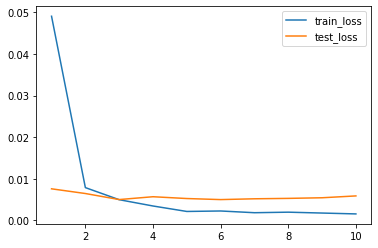

In [16]:
plt.plot(range(1, epochs+1), train_loss, label="train_loss")
plt.plot(range(1, epochs+1), test_loss_, label="test_loss")
plt.legend()

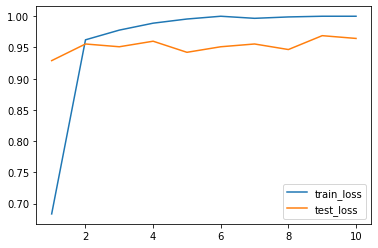

In [38]:
plt.plot(range(1, epochs+1), train_accuracy, label="train_loss")
plt.plot(range(1, epochs+1), test_accuracy_, label="test_loss")
plt.legend()